![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de árboles de decisión y métodos de ensamblaje

En este taller podrá poner en práctica los sus conocimientos sobre construcción e implementación de árboles de decisión y métodos de ensamblajes. El taller está constituido por 9 puntos, 5 relacionados con árboles de decisión (parte A) y 4 con métodos de ensamblaje (parte B).

## Parte A - Árboles de decisión

En esta parte del taller se usará el conjunto de datos de Capital Bikeshare de Kaggle, donde cada observación representa el alquiler de una bicicleta durante una hora y día determinado. Para más detalles puede visitar los siguientes enlaces: [datos](https://github.com/justmarkham/DAT8/blob/master/data/bikeshare.csv), [dicccionario de datos](https://www.kaggle.com/c/bike-sharing-demand/data).

### Datos prestamo de bicicletas

In [26]:
import warnings
warnings.filterwarnings('ignore')

In [27]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz

In [28]:
# Lectura de la información de archivo .csv
bikes = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/bikeshare.csv', index_col='datetime', parse_dates=True)
# Renombrar variable "count" a "total"
bikes.rename(columns={'count':'total'}, inplace=True)
# Crear la hora como una variable 
bikes['hour'] = bikes.index.hour
# Visualización
bikes.head()
bikes.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10886 entries, 2011-01-01 00:00:00 to 2012-12-19 23:00:00
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      10886 non-null  int64  
 1   holiday     10886 non-null  int64  
 2   workingday  10886 non-null  int64  
 3   weather     10886 non-null  int64  
 4   temp        10886 non-null  float64
 5   atemp       10886 non-null  float64
 6   humidity    10886 non-null  int64  
 7   windspeed   10886 non-null  float64
 8   casual      10886 non-null  int64  
 9   registered  10886 non-null  int64  
 10  total       10886 non-null  int64  
 11  hour        10886 non-null  int64  
dtypes: float64(3), int64(9)
memory usage: 1.1 MB


### Punto 1 - Análisis descriptivo

Ejecute las celdas 1.1 y 1.2. A partir de los resultados realice un análisis descriptivo sobre las variables hour y workingday, escriba sus inferencias sobre los datos. Para complementar su análisis puede usar métricas como máximo, mínimo, percentiles entre otros.

In [8]:
# Celda 1.1
print('Promedio de bicicletas rentadas por \n{0}:'.format(bikes.groupby('workingday').total.mean()))
print(bikes.groupby('workingday').total.describe().T)
print(bikes.total.describe().T)




Promedio de bicicletas rentadas por 
workingday
0    188.506621
1    193.011873
Name: total, dtype: float64:
workingday            0            1
count       3474.000000  7412.000000
mean         188.506621   193.011873
std          173.724015   184.513659
min            1.000000     1.000000
25%           44.000000    41.000000
50%          128.000000   151.000000
75%          304.000000   277.000000
max          783.000000   977.000000
count    10886.000000
mean       191.574132
std        181.144454
min          1.000000
25%         42.000000
50%        145.000000
75%        284.000000
max        977.000000
Name: total, dtype: float64


# Análisis descriptivo
***

En promedio, se rentan 188.5 bikes en dias no laborales frente a 193.01 bikes en días laborales. Adicionalmente,  hay un total de 3474 bikes rentadas  en  todos los dias no laborales del dataset, frente a 7412 rentas en total correspondientes a todos los dias laborales del dataset. Obviamente , se espera mas rentas en dias laborales porque son mas días que los no laborales. 

Dado que el perfil de datos respecto a sus percentiles/media y desviación standard con respecto a días laborales/no laborales son muy similares, **esta variable no será tan influyente.**

In [9]:
# Celda 1.2
print('Promedio de bicicletas rentadas por \n{0}:'.format(bikes.groupby('hour').total.mean()))
print(bikes.groupby('hour').total.describe().T)

Promedio de bicicletas rentadas por 
hour
0      55.138462
1      33.859031
2      22.899554
3      11.757506
4       6.407240
5      19.767699
6      76.259341
7     213.116484
8     362.769231
9     221.780220
10    175.092308
11    210.674725
12    256.508772
13    257.787281
14    243.442982
15    254.298246
16    316.372807
17    468.765351
18    430.859649
19    315.278509
20    228.517544
21    173.370614
22    133.576754
23     89.508772
Name: total, dtype: float64:
hour           0           1           2           3           4           5   \
count  455.000000  454.000000  448.000000  433.000000  442.000000  452.000000   
mean    55.138462   33.859031   22.899554   11.757506    6.407240   19.767699   
std     43.620012   34.112105   26.110267   12.666442    4.217633   12.784293   
min      2.000000    1.000000    1.000000    1.000000    1.000000    1.000000   
25%     24.000000   11.000000    5.000000    3.000000    3.000000    8.000000   
50%     41.000000   19.000000   11.

# Análisis descriptivo
***

En promedio, se rentan 362.69 bikes a las 8 de la mañana configurandose como uno de los máximos locales;  a las 17:00, hay un promedio de 469.76 bikes rentadas lo cual corresponde a un máximo promedio de renta. También, hay un mínimo promedio a las 4 am de 6.40 bikes rentadas.

Dado que el perfil de datos respecto a sus percentiles/media y desviación standard con respecto a las horas presentan una marcada diferencia, **esta variable podría  ser muy  influyente.**

### Punto 2 - Análisis de gráficos

Primero ejecute la celda 2.1 y asegúrese de comprender el código y el resultado. Luego, en cada una de celdas 2.2 y 2.3 escriba un código que genere una gráfica de las rentas promedio por hora cuando la variable "workingday" es igual a 0 e igual a 1, respectivamente. Analice y escriba sus hallazgos.

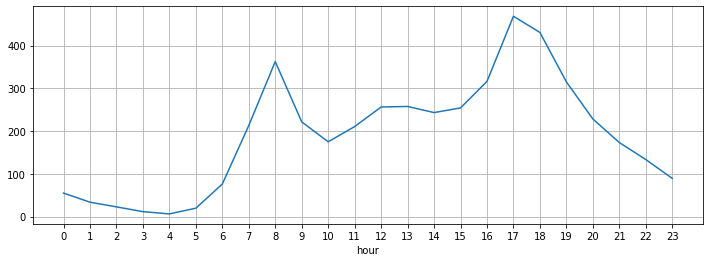

In [10]:
# Celda 2.1 - rentas promedio para cada valor de la variable "hour"
bikes.groupby('hour').total.mean().plot(grid=True, xticks= range(0,24),  figsize=(12, 4))

# Análisis descriptivo
***
Hay dos máximos relevantes en la renta promedio de bicicletas que corresponde seguramente a la hora de entrada a los trabajos ( 8 am) y hora de salida (5pm).  Igualmente entre 12 am y 1 pm , hay uno notorio renta de bikes que debería corresponder a la hora de almuerzo.
Tambien hay un mínimo promedio a las 4 am que seguramente corresponde a la entrada/salida de ciertas trabajos especiales.

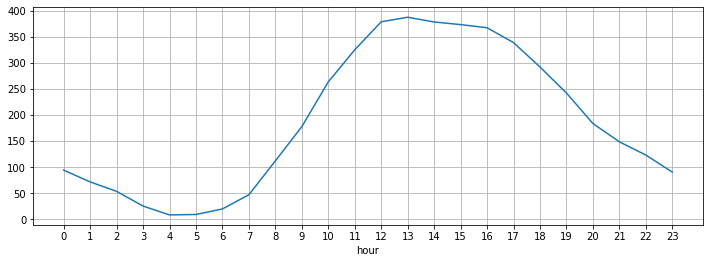

In [11]:
# Celda 2.2 - "workingday"=0 escriba su código y hallazgos 
bikes[bikes.workingday == 0].groupby('hour').total.mean().plot(grid=True,xticks= range(0,24),  figsize=(12, 4))

# Análisis descriptivo
En los días no laborales,hay un marcada aumento en promedio de renta de bicicletas entre las 12am y las 4pm, que hace sentido con quizás, los paseos de descanso o los almuerzos familiares. 

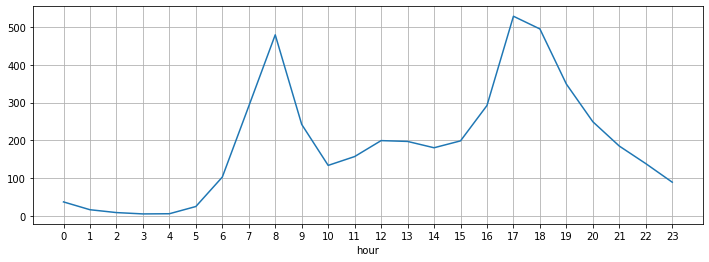

In [12]:
# Celda 2.3 - "workingday"=1 escriba su código y hallazgos 
bikes[bikes.workingday == 1].groupby('hour').total.mean().plot(grid=True,xticks= range(0,24),  figsize=(12, 4))

# Análisis descriptivo
En los dias  laborales,se confirma un  marcada aumento en promedio de renta de bicicletas entre 7 am y 8 am (hora de entrada en los trabajos) , a las 12am y 1pm( hora de almuerzo) y entre 5 pm y 6pm(hora de salida del trabajo)

### Punto 3 - Regresión lineal
En la celda 3 ajuste un modelo de regresión lineal a todo el conjunto de datos, utilizando "total" como variable de respuesta y "hour" y "workingday" como las únicas variables predictoras. Luego, imprima los coeficientes e interprételos. ¿Cuáles son las limitaciones de la regresión lineal en este caso?

In [29]:
# Celda 3
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
features = ['workingday', 'hour']
X= bikes[features]
y= bikes.total


reg = LinearRegression()
reg.fit(X,y)
rmse_scores=np.sqrt(-cross_val_score(reg, X,y, cv=10, scoring='neg_mean_squared_error'))
print(f'Score Media RMSE:{rmse_scores.mean()}')
print(f'Score Standart Deviation RMSE:{rmse_scores.std()}')
print(f'Score Media R2:{reg.score(X,y)}')
print(f'Coeficientes {reg.coef_}')
print(f'Intercepto {reg.intercept_}')






Score Media RMSE:165.22328668912974
Score Standart Deviation RMSE:39.42354316690923
Score Media R2:0.16059115011434866
Coeficientes [ 4.07248627 10.49206282]
Intercepto 67.70595026191623


# Análisis
***

El resultado de la regresion lineal fue:
	$\hat{y}=67.70 + 4.072*workingday +  10.49 * hour $

Observando el coeficiente  de determinacion R2, este es de 0.16 el cual es  muy pobre. Esto significa que esta regresion solamente puede explicar el 16 % de la variabilidad de rentas de bikes y de aqui es un modelo que  no ajusta correctamente a un hyperplano.

En lo que respecta a los coeficientes, cuando es un dia laboral, este incrementa en 4.072 unidades las rentas de ciclas;  mientras que por un aumento de una hora en la reg lineal, hay un incremento en la renta de bikes de 10.49.  Aqui es donde se puede observar , la **poca flexibilidad de este modelo**, porque no captura la realidad del comportamiento de la variable renta de ciclas , respecto a la hora.  

La metrica de desempeno usada fue RMSE y con un valor de 165.223 y una desviacion standart de 39.42




### Punto 4 - Árbol de decisión manual
En la celda 4 cree un árbol de decisiones para pronosticar la variable "total" iterando **manualmente** sobre las variables "hour" y  "workingday". El árbol debe tener al menos 6 nodos finales.

In [33]:
import numpy as np

def calc_mse(ytrue, pred) -> float:
  return np.average(np.square(ytrue-pred))

def mse_split(X_col, y, split):
  filter_l = X_col  < split
  y_l = y.loc[filter_l]
  y_r = y.loc[~filter_l]
  mse_l = calc_mse(y_l, y_l.mean())
  mse_r = calc_mse(y_r, y_r.mean())
  return mse_l + mse_r


def best_split(X, y, num_pct=10):
    features = range(X.shape[1])
    mse_base = calc_mse(y, y.mean())
    best_split = [0, 0, mse_base]  # j, split, mse
    # Para todas las varibles 
    for j in features:
      if len(X.iloc[:, j])<=0:
        break 
      splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
      splits = np.unique(splits)[1:]
      print(f'Splits {splits}')
      # Para cada partición
      for split in splits:
        mse_subnodos= mse_split(X.iloc[:, j], y, split)
        if (mse_subnodos < best_split[2]):              
          best_split = [j, split, mse_subnodos]
            
    return best_split

    # Definición de la función tree_grow para hacer un crecimiento recursivo del árbol
def tree_grow(X, y, level=0,  num_leaf_nodes=0,min_leaf_nodes=None,max_depth=None, num_pct=10):
    
    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0],  level=level, split=-1, n_samples=1, mse=0)
        return tree
    
    # Calcular la mejor división
    j, split, mse = best_split(X, y, num_pct)
    
    # Guardar el árbol y estimar la predicción
    y_pred = y.mean()
    tree = dict(y_pred=y_pred, level=level, split=-1, n_samples=X.shape[0], mse=mse)
    # Revisar el criterio de parada 
    if split == -1:
      if min_leaf_nodes is not None:
        if num_leaf_nodes + 1 <= min_leaf_nodes:
          num_leaf_nodes= num_leaf_nodes + 1
      
    #  return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]
   

    # Siguiente iteración para cada partición
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, num_leaf_nodes, min_leaf_nodes=min_leaf_nodes,max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, num_leaf_nodes, min_leaf_nodes=min_leaf_nodes,max_depth=max_depth, num_pct=num_pct)
    return tree

tree_grow(X, y, level=0, num_leaf_nodes=0, min_leaf_nodes=6, max_depth = 10, num_pct=10)


Splits [1.]
Splits [ 2.  4.  6.  8. 10. 13. 15. 17. 19. 21.]
Splits [1.]
Splits [1. 2. 3. 4. 5.]
Splits [1.]
Splits [1. 2. 3. 4. 5.]
Splits [1.]
Splits [1. 2. 3. 4. 5.]
Splits [1.]
Splits [1. 2. 3. 4. 5.]
Splits [1.]
Splits [1. 2. 3. 4. 5.]
Splits [1.]
Splits [1. 2. 3. 4. 5.]
Splits [1.]
Splits [1. 2. 3. 4. 5.]
Splits [1.]
Splits [1. 2. 3. 4. 5.]
Splits [1.]
Splits [1. 2. 3. 4. 5.]
Splits [1.]
Splits [1. 2. 3. 4. 5.]
Splits [1.]
Splits [ 7.  9. 10. 12. 14. 15. 17. 19. 20. 22.]
Splits [1.]
Splits [ 7.  9. 10. 12. 14. 15. 17. 19. 20. 22.]
Splits [1.]
Splits [ 7.  9. 10. 12. 14. 15. 17. 19. 20. 22.]
Splits [1.]
Splits [ 7.  9. 10. 12. 14. 15. 17. 19. 20. 22.]
Splits [1.]
Splits [ 7.  9. 10. 12. 14. 15. 17. 19. 20. 22.]
Splits [1.]
Splits [ 7.  9. 10. 12. 14. 15. 17. 19. 20. 22.]
Splits [1.]
Splits [ 7.  9. 10. 12. 14. 15. 17. 19. 20. 22.]
Splits [1.]
Splits [ 7.  9. 10. 12. 14. 15. 17. 19. 20. 22.]
Splits [1.]
Splits [ 7.  9. 10. 12. 14. 15. 17. 19. 20. 22.]
Splits [1.]
Splits [ 7.  9. 10

{'level': 0,
 'mse': 32157.945318004182,
 'n_samples': 10886,
 'sl': {'level': 1,
  'mse': 945.7802636532437,
  'n_samples': 2684,
  'sl': {'level': 2,
   'mse': nan,
   'n_samples': 0,
   'sl': {'level': 3,
    'mse': nan,
    'n_samples': 0,
    'sl': {'level': 4,
     'mse': nan,
     'n_samples': 0,
     'sl': {'level': 5,
      'mse': nan,
      'n_samples': 0,
      'sl': {'level': 6,
       'mse': nan,
       'n_samples': 0,
       'sl': {'level': 7,
        'mse': nan,
        'n_samples': 0,
        'sl': {'level': 8,
         'mse': nan,
         'n_samples': 0,
         'sl': {'level': 9,
          'mse': nan,
          'n_samples': 0,
          'sl': {'level': 10,
           'mse': nan,
           'n_samples': 0,
           'split': -1,
           'y_pred': nan},
          'split': [0, 0],
          'sr': {'level': 10,
           'mse': nan,
           'n_samples': 0,
           'split': -1,
           'y_pred': nan},
          'y_pred': nan},
         'split': [0, 0],
    

# Clarificaciones
***

- Se creó una nueva función llamada *calc_mse* la cual calcula el mse.
- Se creó una nueva función llamada  *mse_split* el cual calcula el mse de la particion binaria, y ésta invoca consume la función *calc_mse*.

- Se modificó la función best_split  para incorporar la función *mse_split*

### Punto 5 - Árbol de decisión con librería
En la celda 5 entrene un árbol de decisiones con la **librería sklearn**, usando las variables predictoras "hour" y "workingday" y calibre los parámetros que considere conveniente para obtener un mejor desempeño. Comente el desempeño del modelo con alguna métrica de desempeño de modelos de clasificación y compare desempeño con el modelo del punto 3.

MIN MSE 114.64345547520414 fue obtenido con un arbol de Profundidad=10
Score Media RMSE:107.57576561312104
Score Standart Deviation RMSE:39.63050007312498
            Importancia
workingday      0.18495
hour            0.81505


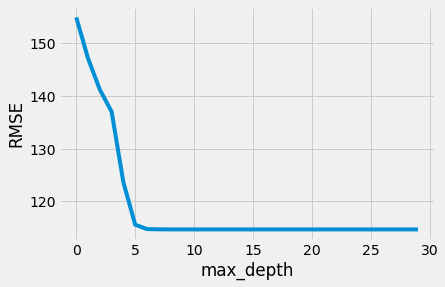

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from sklearn.tree import DecisionTreeRegressor
import math
rmse_scores=[]
for depth in range(30):
  reg= DecisionTreeRegressor(max_depth=depth+1,random_state=101)
  mse=-cross_val_score(reg, X,y, cv=10, scoring='neg_mean_squared_error').mean()
  rmse_scores.append(np.sqrt(mse))
index_min= np.argmin(rmse_scores)
min_rmse= np.min(rmse_scores)
print(f'MIN MSE {min_rmse} fue obtenido con un arbol de Profundidad={index_min+1}')

# Obteniendo la evaluacion del desempeno de este arbol final con 10 niveles de profundida
reg= DecisionTreeRegressor(max_depth=index_min+1,random_state=101)
reg.fit(X,y)
mse=-cross_val_score(reg, X, y, cv=10,scoring='neg_mean_squared_error')
rmse= np.sqrt(mse)

print(f'Score Media RMSE:{rmse.mean()}')
print(f'Score Standart Deviation RMSE:{rmse.std()}')
df =pd.DataFrame(index=X.columns,data= reg.feature_importances_, columns=["Importancia"]).sort_values("Importancia")
print(df)

# Gráfica max_depth versus RMSE (error del modelo)
plt.plot(range(30), rmse_scores)
plt.xlabel('max_depth')
plt.ylabel('RMSE')
plt.show()


#Comparación 
***

Usando la métrica del MSE (para ser mas específico, la raíz cuadrada del MSE), se obtuvo un mejor desempeno en el árbol de decisión de profundidad de 10 niveles y cuyo RMSE fue de 107.575, con respecto a la regresión lineal cuyo RMSE fue de 165.5.  
POr otro lado, la desviacion standart de las dos medidas estan casi del mismo orden.   
Este mejor comportamiento se debe que el árbol de decision es no lineal (más flexible) en contraste con la regresión lineal.  
Respecto a la importancia de los features, se confirma la intuición en el análisis preliminar de perfilamento(EDA) de Datos en donde workingday no seria tan influyente.

| Variable | Importancia |
| --- |  --- |
| hour | 0.184 |
| workingday | 0.815 |

Dado esta no linealidad, el árbol de decision captura mejor el patron de comportamiento de la variable hour al hacer las particiones binarias, en contraste a la regresión lineal que con el coeficiente de 10.49 es interpretado que con cada incremento  de una hora, hay un incremento en la renta de bikes de 10.49 unidades; lo cual no refleja el comportamiento variado durante el dia de renta de bykes.
Aqui se demuestra, el arbol de decision es mas FLEXIBLE con respecto a la regression lineal.


## Parte B - Métodos de ensamblajes
En esta parte del taller se usará el conjunto de datos de Popularidad de Noticias Online. El objetivo es predecir la cantidad de reacciones en redes sociales (popularidad) de la notica. Para más detalles puede visitar el sigueinte enlace: [datos](https://archive.ics.uci.edu/ml/datasets/online+news+popularity).

### Datos popularidad de noticias

In [17]:
# Lectura de la información de archivo .csv
df = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/mashable.csv', index_col=0)
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,Popular
0,http://mashable.com/2014/12/10/cia-torture-rep...,28.0,9.0,188.0,0.732620,1.0,0.844262,5.0,1.0,1.0,...,0.200000,0.80,-0.487500,-0.60,-0.250000,0.9,0.8,0.4,0.8,1
1,http://mashable.com/2013/10/18/bitlock-kicksta...,447.0,7.0,297.0,0.653199,1.0,0.815789,9.0,4.0,1.0,...,0.160000,0.50,-0.135340,-0.40,-0.050000,0.1,-0.1,0.4,0.1,0
2,http://mashable.com/2013/07/24/google-glass-po...,533.0,11.0,181.0,0.660377,1.0,0.775701,4.0,3.0,1.0,...,0.136364,1.00,0.000000,0.00,0.000000,0.3,1.0,0.2,1.0,0
3,http://mashable.com/2013/11/21/these-are-the-m...,413.0,12.0,781.0,0.497409,1.0,0.677350,10.0,3.0,1.0,...,0.100000,1.00,-0.195701,-0.40,-0.071429,0.0,0.0,0.5,0.0,0
4,http://mashable.com/2014/02/11/parking-ticket-...,331.0,8.0,177.0,0.685714,1.0,0.830357,3.0,2.0,1.0,...,0.100000,0.55,-0.175000,-0.25,-0.100000,0.0,0.0,0.5,0.0,0


In [18]:
# Definición variable de interes y variables predictoras
X = df.drop(['url', 'Popular'], axis=1)
y = df['Popular']
df.Popular.value_counts()
df.isnull().sum()

url                             0
timedelta                       0
n_tokens_title                  0
n_tokens_content                0
n_unique_tokens                 0
                               ..
title_subjectivity              0
title_sentiment_polarity        0
abs_title_subjectivity          0
abs_title_sentiment_polarity    0
Popular                         0
Length: 61, dtype: int64

In [19]:
# División de la muestra en set de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

### Punto 6 - Árbol de decisión y regresión logística
En la celda 6 construya un árbol de decisión y una regresión logística. Para el árbol calibre al menos un parámetro y evalúe el desempeño de cada modelo usando las métricas de Accuracy y F1-Score.

In [22]:
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, accuracy_score
log_reg= LogisticRegression()
log_reg.fit(X_train,y_train)
yPred= log_reg.predict(X_test)
print(f'F1-SCORE REG. LOGISTICA: {f1_score(y_test , yPred)}')
print (f'ACCURACY REG. LOGISTICA: {accuracy_score(y_test , yPred)}')

#Nivel de Balanceo de clases representada por la columna Popular
print(f'Nivel de balanceo de clases\n {df.Popular.value_counts()}') 
error_scores= []
for depth in range(1,21):
  tree= DecisionTreeClassifier(max_depth=depth,random_state=101)
  tree.fit(X_train,y_train)
  yPred= tree.predict(X_test)
  error_scores.append(1-accuracy_score(y_test , yPred))


index_min= np.argmin(error_scores)
min_error= np.min(error_scores)
print(f'MIN ERROR {min_error} fue obtenido con un arbol de Profundidad={index_min+1}')

# Obteniendo la evaluacion del desempeno de este arbol final con 4 niveles de profundidad
tree= DecisionTreeClassifier(max_depth=index_min+1,random_state=101)
tree.fit(X_train,y_train)
yPred= tree.predict(X_test)

print(f'F1-SCORE ARBOL: {f1_score(y_test , yPred)}')
print (f'ACCURACY ARBOL: {accuracy_score(y_test , yPred)}')



F1-SCORE REG. LOGISTICA: 0.6106254203093476
ACCURACY REG. LOGISTICA: 0.614
Nivel de balanceo de clases
 1    3000
0    3000
Name: Popular, dtype: int64
MIN ERROR 0.3486666666666667 fue obtenido con un arbol de Profundidad=4
F1-SCORE ARBOL: 0.6345213137665969
ACCURACY ARBOL: 0.6513333333333333


# Análisis
***
- Las clases son balanceadas
- F1-Score regresión logística = 0.6106  
  Accuracy regresión logística = 0.614

- Después de hacer ajuste del parámetro de profundidad, se obtuvo un árbol con menos error (mayor accuracy) de profundidad = 4 niveles. 
- Con este árbol de 4 niveles de profundidad, se obtuvo:  

  F1-Score: 0.634  

  Accuracy: 0.651  

- En conclusión,  el desempeno del árbol fue mejor.
  



### Punto 7 - Votación Mayoritaria
En la celda 7 elabore un esamble con la metodología de **Votación mayoritaria** compuesto por 300 muestras bagged para cada uno de los siguientes escenarios:

-100 árboles de decisión donde max_depth = None\
-100 árboles de decisión donde max_depth = 2\
-100 regresiones logísticas

Evalúe los modelos utilizando las métricas de Accuracy y F1-Score.

In [23]:
from sklearn.tree import DecisionTreeClassifier



#Creacion de muestras boostrap paa todos los experimentos
n_estimators = 100
n_samples=300
np.random.seed(123)
samples = [np.random.choice(a=X_train.shape[0], size=X_train.shape[0], replace=True) for _ in range(n_samples)]

#EXPERIMENTO 1.1 - BAGGING MANUAL

# Entrenamiento de 100 arboles con las 300 muestras boostrap
np.random.seed(123) 
seeds = np.random.randint(1, 10000, size=n_estimators)
trees = {}
#Construir 3 muestras bootstrap  para cada estimador.
for index in range(n_estimators):
    trees[index] = DecisionTreeClassifier(max_features="sqrt", max_depth=None, random_state=seeds[index])
    XTrain= pd.concat([ X_train.iloc[samples[index*3]], X_train.iloc[samples[(index*3 + 1)]] , X_train.iloc[samples[(index*3 + 2)]]])
    yTrain= pd.concat([ y_train.iloc[samples[index*3]], y_train.iloc[samples[(index*3 + 1)]] , y_train.iloc[samples[(index*3 + 2)]]])
    trees[index].fit(XTrain, yTrain)
  
# Predicción para los datos del set de test con cada modelo
yPred_df = pd.DataFrame(index=X_test.index, columns=list(range(n_estimators)))
for i in range(n_estimators):
    yPred_df.iloc[:, i] = trees[i].predict(X_test)

# Votación mayoritaria
yPred = (yPred_df.sum(axis=1) >= (n_estimators / 2)).astype(np.int)

# Desempeño al hacer votación mayoritaria
print(f'F1-SCORE BAGGING CON ARBOLES EXPERIMENTO 1.1(BAGGING MANUAL votación mayoritaria): {f1_score(y_test , yPred)}')
print (f'ACCURACY BAGGING CON ARBOLES EXPERIMENTO 1.1(BAGGING MANUAL votación mayoritaria): {accuracy_score(y_test , yPred)}')
print (f'\n')

#EXPERIMENTO 1.2 - BAGGING CON SKLEARN

from sklearn.ensemble import BaggingClassifier
clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_features="sqrt", max_depth=None, random_state=42),
                        n_estimators=100, max_samples=300, bootstrap=True,
                        random_state=42, n_jobs=-1, oob_score=True)

clf.fit(X_train, y_train)
yPred = clf.predict(X_test)
# Desempeño al hacer votación mayoritaria
print(f'F1-SCORE BAGGING CON ARBOLES EXPERIMENTO 1.2(BAGGING SKLEARN votación mayoritaria): {f1_score(y_test , yPred)}')
print (f'ACCURACY BAGGING CON ARBOLES EXPERIMENTO 1.2(BAGGING SKLEARN votación mayoritaria): {accuracy_score(y_test , yPred)}')
print (f'\n')




#EXPERIMENTO 2.1 -BAGGING MANUAL-

# Entrenamiento de 100 arboles con las 300 muestras boostrap
np.random.seed(123) 
seeds = np.random.randint(1, 10000, size=n_estimators)
trees = {}

#Construir 3 muestras bootstrap  para cada estimador.
for index in range(n_estimators):
    trees[index] = DecisionTreeClassifier(max_features="sqrt", max_depth=2, random_state=seeds[index])
    XTrain= pd.concat([ X_train.iloc[samples[index*3]], X_train.iloc[samples[(index*3 + 1)]] , X_train.iloc[samples[(index*3 + 2)]]])
    yTrain= pd.concat([ y_train.iloc[samples[index*3]], y_train.iloc[samples[(index*3 + 1)]] , y_train.iloc[samples[(index*3 + 2)]]])
    trees[index].fit(XTrain, yTrain)
  
# Predicción para los datos del set de test con cada modelo
yPred_df = pd.DataFrame(index=X_test.index, columns=list(range(n_estimators)))
for i in range(n_estimators):
    yPred_df.iloc[:, i] = trees[i].predict(X_test)

# Votación mayoritaria
yPred = (yPred_df.sum(axis=1) >= (n_estimators / 2)).astype(np.int)

# Desempeño al hacer votación mayoritaria
print(f'F1-SCORE BAGGING CON ARBOLES EXPERIMENTO 2.1(BAGGING MANUAL votación mayoritaria): {f1_score(y_test , yPred)}')
print (f'ACCURACY BAGGING CON ARBOLES EXPERIMENTO 2.1 (BAGGING MANUAL votación mayoritaria): {accuracy_score(y_test , yPred)}')
print (f'\n')


#EXPERIMENTO 2.2 - BAGGING CON SKLEARN

from sklearn.ensemble import BaggingClassifier
clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_features="sqrt", max_depth=2, random_state=42), 
                        n_estimators=100, max_samples=300, bootstrap=True,
                        random_state=42, n_jobs=-1, oob_score=True)

clf.fit(X_train, y_train)
yPred = clf.predict(X_test)
# Desempeño al hacer votación mayoritaria
print(f'F1-SCORE ARBOL EXPERIMENTO 2.2(BAGGING SKLEARN votación mayoritaria): {f1_score(y_test , yPred)}')
print (f'ACCURACY ARBOL EXPERIMENTO 2.2(BAGGING SKLEARN votación mayoritaria): {accuracy_score(y_test , yPred)}')
print (f'\n')

#EXPERIMENTO 3.1 - BAGGING MANUAL CON REG. LOGISTICA

# Entrenamiento de 100 regressiones logisticas con las 300 muestras boostrap
np.random.seed(123) 
seeds = np.random.randint(1, 10000, size=n_estimators)
logs = {}
for index in range(n_estimators):
    logs[index] = LogisticRegression(random_state=seeds[index])
    XTrain= pd.concat([ X_train.iloc[samples[index*3]], X_train.iloc[samples[(index*3 + 1)]] , X_train.iloc[samples[(index*3 + 2)]]])
    yTrain= pd.concat([ y_train.iloc[samples[index*3]], y_train.iloc[samples[(index*3 + 1)]] , y_train.iloc[samples[(index*3 + 2)]]])
    logs[index].fit(XTrain, yTrain)
  
# Predicción para los datos del set de test con cada modelo
yPred_df = pd.DataFrame(index=X_test.index, columns=list(range(n_estimators)))
for i in range(n_estimators):
    yPred_df.iloc[:, i] = logs[i].predict(X_test)

# Votación mayoritaria
yPred = (yPred_df.sum(axis=1) >= (n_estimators / 2)).astype(np.int)
# Desempeño al hacer votación mayoritaria
print(f'F1-SCORE BAGGING CON REGRESSION LOGISTICA EXPERIMENTO 3.1(BAGGING MANUAL votación mayoritaria): {f1_score(y_test , yPred)}')
print (f'ACCURACY BAGGING CON REGRESSION LOGISTICA EXPERIMENTO 3.1(BAGGING MANUAL votación mayoritaria): {accuracy_score(y_test , yPred)}')
print (f'\n')


# EXPERIMENTO 3.2 BAGGING CON REG. LOGISTICA SKLEARN
clf = BaggingClassifier(base_estimator= LogisticRegression(random_state=42), 
                        n_estimators=100, max_samples=300, bootstrap=True,
                        random_state=42, n_jobs=-1, oob_score=True)

clf.fit(X_train, y_train)
yPred = clf.predict(X_test)
# Desempeño al hacer votación mayoritaria
print(f'F1-SCORE BAGGING CON REGRESSION LOGISTICA EXPERIMENTO 3.2( BAGGING SKLEARN votación mayoritaria): {f1_score(y_test , yPred)}')
print (f'ACCURACY BAGGING  CON REGRESSION LOGISTICA EXPERIMENTO 3.2 (BAGGING SKLEARN votación mayoritaria): {accuracy_score(y_test , yPred)}')

F1-SCORE BAGGING CON ARBOLES EXPERIMENTO 1.1(BAGGING MANUAL votación mayoritaria): 0.6735617323852617
ACCURACY BAGGING CON ARBOLES EXPERIMENTO 1.1(BAGGING MANUAL votación mayoritaria): 0.6633333333333333


F1-SCORE BAGGING CON ARBOLES EXPERIMENTO 1.2(BAGGING SKLEARN votación mayoritaria): 0.649932157394844
ACCURACY BAGGING CON ARBOLES EXPERIMENTO 1.2(BAGGING SKLEARN votación mayoritaria): 0.656


F1-SCORE BAGGING CON ARBOLES EXPERIMENTO 2.1(BAGGING MANUAL votación mayoritaria): 0.6577896138482024
ACCURACY BAGGING CON ARBOLES EXPERIMENTO 2.1 (BAGGING MANUAL votación mayoritaria): 0.6573333333333333


F1-SCORE ARBOL EXPERIMENTO 2.2(BAGGING SKLEARN votación mayoritaria): 0.640218878248974
ACCURACY ARBOL EXPERIMENTO 2.2(BAGGING SKLEARN votación mayoritaria): 0.6493333333333333


F1-SCORE BAGGING CON REGRESSION LOGISTICA EXPERIMENTO 3.1(BAGGING MANUAL votación mayoritaria): 0.6152805949966192
ACCURACY BAGGING CON REGRESSION LOGISTICA EXPERIMENTO 3.1(BAGGING MANUAL votación mayoritaria): 0.6

# Clarificaciones
***

Dado la ambiguedad del enunciado (100 estimadores con 300 muestras bagged),se corrieron 6 experimentos, para representar 2 escenarios: 100 estimadores con 300 muestras **boostraps** y 100 estimadores con 100 muestras boostraps de longitud(max_sample)=300:
- Experimento [1.1], [2.1] y [3.1] corresponde a bagging manual en la cual  tres muestras boostraps le correponde a cada estimador. Para contruir las tres muestras boostraps por cada estimador, se uso un mecanismo de concatenacion.

- Experimento [1.2], [2.2] y [3.3] corresponde a bagging con sklearn en la cual se ajustan los valores de max_samples y boostrap=True


### Punto 8 - Votación Ponderada
En la celda 8 elabore un ensamble con la metodología de **Votación ponderada** compuesto por 300 muestras bagged para los mismos tres escenarios del punto 7. Evalúe los modelos utilizando las métricas de Accuracy y F1-Score

In [24]:
from sklearn.tree import DecisionTreeClassifier

def VotacionPonderada(ensamblaje,samples_bootstrap, n_samples,n_estimadores, XTrain,yTrain,yPred):
  samples_oob = []
  # Obtención de las observaciones fuera de la bolsa "out-of-bag" para cada muestra
  for i in range(n_estimators):
    samples_oob.append(sorted(set(range(n_samples)) - 
                              set(samples_bootstrap[i*3]) -
                              set(samples_bootstrap[i*3+1])- 
                              set(samples_bootstrap[i*3+2])))
  #for i,sample in enumerate(samples_bootstrap):
  #  samples_oob.append(sorted(set(range(n_samples)) - set(sample[i])-))
  # Estimación de los errores OOB para cada clasificador
  errors = np.zeros(n_estimators)
  for i in range(n_estimators):

    if len(samples_oob[i])>0:
      y_pred_ = ensamblaje[i].predict(XTrain.iloc[samples_oob[i]])
      errors[i] = 1 - accuracy_score(yTrain.iloc[samples_oob[i]], y_pred_)
    else:
      y_pred_ = ensamblaje[i].predict(XTrain)
      errors[i] = 1 - accuracy_score(yTrain, y_pred_)
   
  # Obtención de los pesos alpha de cada modelo de acuerdo al error OOB
  alpha = (1 - errors) / (1 - errors).sum()
  weighted_sum_1 = ((yPred) * alpha).sum(axis=1)
  y_pred = (weighted_sum_1 >= 0.5).astype(np.int)
  return y_pred


#Creacion de muestras boostrap paa todos los experimentos
n_estimators = 100
n_samples=300
np.random.seed(123)
samples = [np.random.choice(a=X_train.shape[0], size=X_train.shape[0], replace=True) for _ in range(n_samples)]

#EXPERIMENTO 1.1 - BAGGING MANUAL . Cada estimador le corresponde 3 muestras boostrap.


# Entrenamiento de 100 arboles con las 300 muestras boostrap
np.random.seed(123) 
seeds = np.random.randint(1, 10000, size=n_estimators)
trees = {}
# Construir 3 muestrasp boostrap por cada estimador
for index in range(n_estimators):
    trees[index] = DecisionTreeClassifier(max_features="sqrt", max_depth=None, random_state=seeds[index])
    XTrain= pd.concat([ X_train.iloc[samples[index*3]], X_train.iloc[samples[(index*3 + 1)]] , X_train.iloc[samples[(index*3 + 2)]]])
    yTrain= pd.concat([ y_train.iloc[samples[index*3]], y_train.iloc[samples[(index*3 + 1)]] , y_train.iloc[samples[(index*3 + 2)]]])
    trees[index].fit(XTrain, yTrain)
  
# Predicción para los datos del set de test con cada modelo
yPred_df = pd.DataFrame(index=X_test.index, columns=list(range(n_estimators)))
for i in range(n_estimators):
    yPred_df.iloc[:, i] = trees[i].predict(X_test)

# Votación ponderada
yPred = VotacionPonderada(trees, samples, n_estimators, n_samples,XTrain , yTrain, yPred_df )

# Desempeño al hacer votación ponderada
print(f'F1-SCORE BAGGING CON ARBOLES EXPERIMENTO 1.1 (BAGGING MANUAL -votación ponderada): {f1_score(y_test , yPred)}')
print (f'ACCURACY BAGGING CON ARBOLES EXPERIMENTO 1.1 (BAGGING MANUAL -votación ponderada): {accuracy_score(y_test , yPred)}')
print (f'\n')

#EXPERIMENTO 1.2 - BAGGING CON SKLEARN 

from sklearn.ensemble import BaggingClassifier
clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_features="sqrt", max_depth=None, random_state=42),
                        n_estimators=100, max_samples=300, bootstrap=True,
                        random_state=42, n_jobs=-1, oob_score=True)

clf.fit(X_train, y_train)
# Obtención de los pesos alpha de cada modelo de acuerdo al error OOB
errors = np.zeros(clf.n_estimators)
y_pred_all_ = np.zeros((X_test.shape[0], clf.n_estimators))

for i in range(clf.n_estimators):
    oob_sample = ~clf.estimators_samples_[i]
    y_pred_ = clf.estimators_[i].predict(X_train.values[oob_sample])
    errors[i] = accuracy_score(y_pred_, y_train.values[oob_sample])
    y_pred_all_[:, i] = clf.estimators_[i].predict(X_test)
    
alpha = (1 - errors) / (1 - errors).sum()
yPred = (np.sum(y_pred_all_ * alpha, axis=1) >= 0.5).astype(np.int)

# Desempeño al hacer votación ponderada
print(f'F1-SCORE BAGGING CON ARBOLES EXPERIMENTO 1.2(BAGGING SKLEARN votación ponderada): {f1_score(y_test , yPred)}')
print (f'ACCURACY BAGGING CON ARBOLES EXPERIMENTO 1.2(BAGGING SKLEARN votación ponderada): {accuracy_score(y_test , yPred)}')
print (f'\n')


#EXPERIMENTO 2.1 - BAGGING MANUAL - Cada estimador le corresponde 3 muestras boostrap.

# Entrenamiento de 100 arboles con las 300 muestras boostrap
np.random.seed(123) 
seeds = np.random.randint(1, 10000, size=n_estimators)
trees = {}
# Construir 3 muestrasp boostrap por cada estimador
for index in range(n_estimators):
    trees[index] = DecisionTreeClassifier(max_features="sqrt", max_depth=2, random_state=seeds[index])
    XTrain= pd.concat([ X_train.iloc[samples[index*3]], X_train.iloc[samples[(index*3 + 1)]] , X_train.iloc[samples[(index*3 + 2)]]])
    yTrain= pd.concat([ y_train.iloc[samples[index*3]], y_train.iloc[samples[(index*3 + 1)]] , y_train.iloc[samples[(index*3 + 2)]]])
    trees[index].fit(XTrain, yTrain)
  
# Predicción para los datos del set de test con cada modelo
yPred_df = pd.DataFrame(index=X_test.index, columns=list(range(n_estimators)))
for i in range(n_estimators):
    yPred_df.iloc[:, i] = trees[i].predict(X_test)

# Votación ponderada
yPred = VotacionPonderada(trees, samples, n_estimators, n_samples,XTrain , yTrain, yPred_df )

# Desempeño al hacer votación ponderada
print(f'F1-SCORE BAGGING CON ARBOLES EXPERIMENTO 2.1(BAGING MANUAL votación ponderada): {f1_score(y_test , yPred)}')
print (f'ACCURACY BAGGING CON ARBOLES EXPERIMENTO 2.1(BAGGIN MANUAL votación ponderada): {accuracy_score(y_test , yPred)}')
print (f'\n')


#EXPERIMENTO 2.2 - BAGGING CON SKLEARN

from sklearn.ensemble import BaggingClassifier
clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_features="sqrt", max_depth=2, random_state=42), 
                        n_estimators=100, max_samples=300, bootstrap=True,
                        random_state=42, n_jobs=-1, oob_score=True)

clf.fit(X_train, y_train)

# Obtención de los pesos alpha de cada modelo de acuerdo al error OOB
errors = np.zeros(clf.n_estimators)
y_pred_all_ = np.zeros((X_test.shape[0], clf.n_estimators))

for i in range(clf.n_estimators):
    oob_sample = ~clf.estimators_samples_[i]
    y_pred_ = clf.estimators_[i].predict(X_train.values[oob_sample])
    errors[i] = accuracy_score(y_pred_, y_train.values[oob_sample])
    y_pred_all_[:, i] = clf.estimators_[i].predict(X_test)
    
alpha = (1 - errors) / (1 - errors).sum()
yPred = (np.sum(y_pred_all_ * alpha, axis=1) >= 0.5).astype(np.int)

# Desempeño al hacer votación ponderada
print(f'F1-SCORE BAGGING CON ARBOLES EXPERIMENTO 2.2(BAGGING SKLEARN votación ponderada): {f1_score(y_test , yPred)}')
print (f'ACCURACY BAGGING CON ARBOLES EXPERIMENTO 2.2(BAGGING SKLEARN votación ponderada): {accuracy_score(y_test , yPred)}')
print (f'\n')


#EXPERIMENTO 3.1 BAGGING MANUAL CON REG.LOGISTICAS

# Entrenamiento de 100 regressiones con las 300 muestras boostrap
np.random.seed(123) 
seeds = np.random.randint(1, 10000, size=n_estimators)
logs = {}
for index in range(n_estimators):
    logs[index] = LogisticRegression(random_state=seeds[index])
    XTrain= pd.concat([ X_train.iloc[samples[index*3]], X_train.iloc[samples[(index*3 + 1)]] , X_train.iloc[samples[(index*3 + 2)]]])
    yTrain= pd.concat([ y_train.iloc[samples[index*3]], y_train.iloc[samples[(index*3 + 1)]] , y_train.iloc[samples[(index*3 + 2)]]])
    logs[index].fit(XTrain, yTrain)
  
# Predicción para los datos del set de test con cada modelo
yPred_df = pd.DataFrame(index=X_test.index, columns=list(range(n_estimators)))
for i in range(n_estimators):
    yPred_df.iloc[:, i] = logs[i].predict(X_test)

# Votación ponderada
yPred = VotacionPonderada(trees, samples, n_estimators, n_samples,XTrain , yTrain, yPred_df )
# Desempeño al hacer votación ponderada
print(f'F1-SCORE BAGGING CON REG LOGISTICA EXPERIMENTO 3.1(BAGGING MANUAL votación ponderada): {f1_score(y_test , yPred)}')
print (f'ACCURACY BAGGING CON REG LOGISTICA EXPERIMENTO 3.1(BAGGING MANUAL votación ponderada): {accuracy_score(y_test , yPred)}')
print (f'\n')


# EXPERIMENTO 3.2 BAGGING CON REG. LOGISTICA SKLEARN
clf = BaggingClassifier(base_estimator= LogisticRegression(random_state=42), 
                        n_estimators=100, max_samples=300, bootstrap=True,
                        random_state=42, n_jobs=-1, oob_score=True)

clf.fit(X_train, y_train)
# Obtención de los pesos alpha de cada modelo de acuerdo al error OOB
errors = np.zeros(clf.n_estimators)
y_pred_all_ = np.zeros((X_test.shape[0], clf.n_estimators))

for i in range(clf.n_estimators):
    oob_sample = ~clf.estimators_samples_[i]
    y_pred_ = clf.estimators_[i].predict(X_train.values[oob_sample])
    errors[i] = accuracy_score(y_pred_, y_train.values[oob_sample])
    y_pred_all_[:, i] = clf.estimators_[i].predict(X_test)
    
alpha = (1 - errors) / (1 - errors).sum()
yPred = (np.sum(y_pred_all_ * alpha, axis=1) >= 0.5).astype(np.int)

# Desempeño al hacer votación ponderada
print(f'F1-SCORE BAGGING CON REGRESSION LOGISTICA EXPERIMENTO 3.2( BAGGING SKLEARN votación ponderada): {f1_score(y_test , yPred)}')
print (f'ACCURACY BAGGING  CON REGRESSION LOGISTICA EXPERIMENTO 3.2 (BAGGING SKLEARN votación ponderada): {accuracy_score(y_test , yPred)}')



F1-SCORE BAGGING CON ARBOLES EXPERIMENTO 1.1 (BAGGING MANUAL -votación ponderada): 0.6701502286087525
ACCURACY BAGGING CON ARBOLES EXPERIMENTO 1.1 (BAGGING MANUAL -votación ponderada): 0.6633333333333333


F1-SCORE BAGGING CON ARBOLES EXPERIMENTO 1.2(BAGGING SKLEARN votación ponderada): 0.6577540106951871
ACCURACY BAGGING CON ARBOLES EXPERIMENTO 1.2(BAGGING SKLEARN votación ponderada): 0.6586666666666666


F1-SCORE BAGGING CON ARBOLES EXPERIMENTO 2.1(BAGING MANUAL votación ponderada): 0.657771847898599
ACCURACY BAGGING CON ARBOLES EXPERIMENTO 2.1(BAGGIN MANUAL votación ponderada): 0.658


F1-SCORE BAGGING CON ARBOLES EXPERIMENTO 2.2(BAGGING SKLEARN votación ponderada): 0.61794500723589
ACCURACY BAGGING CON ARBOLES EXPERIMENTO 2.2(BAGGING SKLEARN votación ponderada): 0.648


F1-SCORE BAGGING CON REG LOGISTICA EXPERIMENTO 3.1(BAGGING MANUAL votación ponderada): 0.6135135135135135
ACCURACY BAGGING CON REG LOGISTICA EXPERIMENTO 3.1(BAGGING MANUAL votación ponderada): 0.6186666666666667


F

# Clarificaciones
***

Dado la ambiguedad del enunciado (100 estimadores con 300 muestras bagged),se corrieron 6 experimentos, para representar 2 escenarios: 100 estimadores con 300 muestras **boostraps** y 100 estimadores con 100 muestras boostraps de longitud(max_sample)=300:
- Experimento [1.1], [2.1] y [3.1] corresponde a bagging manual en la cual  tres muestras boostraps le correponde a cada estimador. Para contruir las tres muestras boostraps por cada estimador, se uso un mecanismo de concatenacion.

- Experimento [1.2], [2.2] y [3.3] corresponde a bagging con sklearn en la cual se ajustan los valores de max_samples y boostrap=True


### Punto 9 - Comparación y análisis de resultados
En la celda 9 comente sobre los resultados obtenidos con las metodologías usadas en los puntos 7 y 8, compare los resultados y enuncie posibles ventajas o desventajas de cada una de ellas.

# Análisis y Conclusiones
***
- El desempeño de los modelos es muy similar entre ambos escenarios de votación mayoritaria y ponderada.

- El de menor desempeño en ambos escenarios  fue la regresión logística pero no por mucho.

- Una limitación de votación mayoritaria es que el ensamblaje trata todos los modelos de la misma forma , significando que todos los modelos contribuyen igualmente en la prediccion. Sin embargo, en el ensamblado usualmente hay unos modelos no tan buenos como otros. 